# H2 dissociation in LDA

In this notebook we calculate the H2 dissociation curve for different crmult.

In [1]:
import os,sys,commands,shutil
import numpy as np
from BigDFT import Calculators as calc
        
#Extract the archive if it exists to avoid running all calculations
tarname = 'log-H2-LDA-dissociation.tar.bz2'
if os.path.exists(tarname):
    print "The tar file %s with all log files exists: we use it avoiding calculations!" % tarname
    import tarfile
    tar = tarfile.open(tarname,"r:bz2")
    #for n in tar.getmembers(): 
    #    print n.name
    tar.extractall()
    tar.close()

The tar file log-H2-LDA-dissociation.tar.bz2 with all log files exists: we use it avoiding calculations!


We do all the calculations...

In [2]:
#Create the posinp file
H_xyz = """\
1 angstroemd0
free
H 0 0 0
"""
open("H.xyz","w").write(H_xyz)

def dimer_xyz(d):
    d_xyz = """\
2 angstroemd0
free
H 0 0 0
H 0 0 {0:14.12f}"""
    return d_xyz.format(d)

#cubic calculations
cubic = {}
cubic["dft"] = { "hgrids": 0.40, 
                     "ixc": "LDA (ABINIT)",
                     "gnrm_cv": 1.e-9, 
                     "rmult": [ 18.0, 8.0]}

#Define a calculator
study = calc.SystemCalculator(skip=True,verbose=False)

#Calculate the reference for the hydrogen atom with a large crmult (18)
study.run(name="H-LDA-%05.2f" % 18.0,input=cubic,posinp="H.xyz")

dists = [0.3,0.4,0.5,0.6,0.7,0.9,1.0,2.0,4.0,5.0,6.0,8.0,10.0]
crmult = [3,6,9,12,15]

for r in crmult:
    #First do the calculaltion with the hydrogen atom
    cubic["dft"]["rmult"][0] = r
    study.run(name="H-LDA-%05.2f" % r,input=cubic,posinp="H.xyz")
    for d in dists:
        prefix = "H2-LDA-%05.2f-%05.2f" % (r,d) #Create the namespace
        open(prefix+".xyz","w").write(dimer_xyz(d)) #Write the posinp file
        study.run(name=prefix,input=cubic,posinp=prefix+".xyz")

Initialize a Calculator with OMP_NUM_THREADS=1 and command /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n H-LDA-18.00 -s Yes
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n H-LDA-03.00 -s Yes
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n H2-LDA-03.00-00.30 -s Yes
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n H2-LDA-03.00-00.40 -s Yes
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n H2-LDA-03.00-00.50 -s Yes
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n H2-LDA-03.00-00.60 -s Yes
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n H2-LDA-03.00-00.70 -s Yes
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n H2-LDA-03.00-00.90 -s Yes
Executing command:  /lo

We collect all information (the names of the log files are useless).

In [3]:
from BigDFT import Logfiles as lf
import glob

#Collect the data
HtoeV = 27.211396132 #Conversion Hartree to meV

#First the reference
lfiles = glob.glob('log-H-LDA-*.yaml')
lfiles.sort()
ref = {'rmult': [], 'energies': [], 'gnrm_cv': [], 'gnrm': [], 'legend': 'H-LDA'}
for fname in lfiles:
    print fname,
    log = lf.Logfile(fname)
    r = float(log.log['dft']['rmult'][0])
    ref['rmult'].append(r)
    ref['gnrm_cv'].append(log.gnrm_cv)
    ref['gnrm'].append(lf.find_iterations(log.log)[-1][-1])
    ref['energies'].append( HtoeV*log.energy)

#Then the dissociation curve
lfiles = glob.glob('log-H2-LDA-*.yaml')
lfiles.sort()
data = {'rmult': [], 'distances': [], 'energies': [], 'forcemax': [], 'gnrm': [], 'legend': 'H2-LDA'}
distances = []
crmult = []
for fname in lfiles:
    print fname,
    log = lf.Logfile(fname)
    r = float(log.log['dft']['rmult'][0])
    d = float(log.log['posinp']['positions'][1]['H'][2])
    if r not in crmult: 
        crmult.append(r)
    if d not in distances:
        distances.append(d)
    #Use the reference from one Hydrogen atom calculation.
    H = lf.Logfile('log-H-LDA-%05.2f.yaml' % r)
    data['rmult'].append(r)
    data['distances'].append(d)
    data['energies'].append( HtoeV*(log.energy - 2.0* H.energy) )
    #data['gnrm_cv'].append(log.gnrm_cv)
    data['gnrm'].append(lf.find_iterations(log.log)[-1][-1])
    data['forcemax'].append(log.forcemax)
#print data
#We sort the distances and crmult
crmult.sort()
distances.sort()
print "\nThere are %d different crmult and %d different distances." % (len(crmult),len(distances))

log-H-LDA-03.00.yaml log-H-LDA-06.00.yaml log-H-LDA-09.00.yaml log-H-LDA-12.00.yaml log-H-LDA-15.00.yaml log-H-LDA-18.00.yaml log-H2-LDA-03.00-00.30.yaml log-H2-LDA-03.00-00.40.yaml log-H2-LDA-03.00-00.50.yaml log-H2-LDA-03.00-00.60.yaml log-H2-LDA-03.00-00.70.yaml log-H2-LDA-03.00-00.90.yaml log-H2-LDA-03.00-01.00.yaml log-H2-LDA-03.00-02.00.yaml log-H2-LDA-03.00-04.00.yaml log-H2-LDA-03.00-05.00.yaml log-H2-LDA-03.00-06.00.yaml log-H2-LDA-03.00-08.00.yaml log-H2-LDA-03.00-10.00.yaml log-H2-LDA-06.00-00.30.yaml log-H2-LDA-06.00-00.40.yaml log-H2-LDA-06.00-00.50.yaml log-H2-LDA-06.00-00.60.yaml log-H2-LDA-06.00-00.70.yaml log-H2-LDA-06.00-00.90.yaml log-H2-LDA-06.00-01.00.yaml log-H2-LDA-06.00-02.00.yaml log-H2-LDA-06.00-04.00.yaml log-H2-LDA-06.00-05.00.yaml log-H2-LDA-06.00-06.00.yaml log-H2-LDA-06.00-08.00.yaml log-H2-LDA-06.00-10.00.yaml log-H2-LDA-09.00-00.30.yaml log-H2-LDA-09.00-00.40.yaml log-H2-LDA-09.00-00.50.yaml log-H2-LDA-09.00-00.60.yaml log-H2-LDA-09.00-00.70.yaml log-H2

## Convergence of the energy for the Hydrogen atom in function of rmult

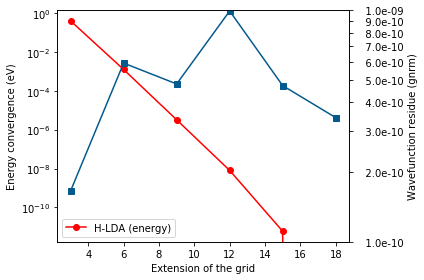

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

ener = [ abs(e - ref['energies'][-1]) for e in ref['energies']]

fig, ax1 = plt.subplots()
ax1.set_yscale('log')
ax1.set_xlabel('Extension of the grid')
ax1.set_ylabel('Energy convergence (eV)')
ax1.plot(ref['rmult'], ener, marker=markers[0], 
             ls='-', label=ref['legend']+' (energy)', color=colors[1])
ax1.legend(loc=3)

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylim(1.e-10,1.e-9)
ax2.set_yticks(np.arange(1.e-10,1.1e-9,1.e-10))
ax2.set_yticklabels([ "%10.1e" % i for i in np.arange(1.e-10,1.1e-9,1.e-10)])
ax2.set_ylabel('Wavefunction residue (gnrm)')
ax2.plot(ref['rmult'], ref['gnrm'], marker=markers[1], 
             ls='-', label=ref['legend'], color=colors[2])
fig.tight_layout()
plt.show()

## H2 dissociation energy curve for different rmult

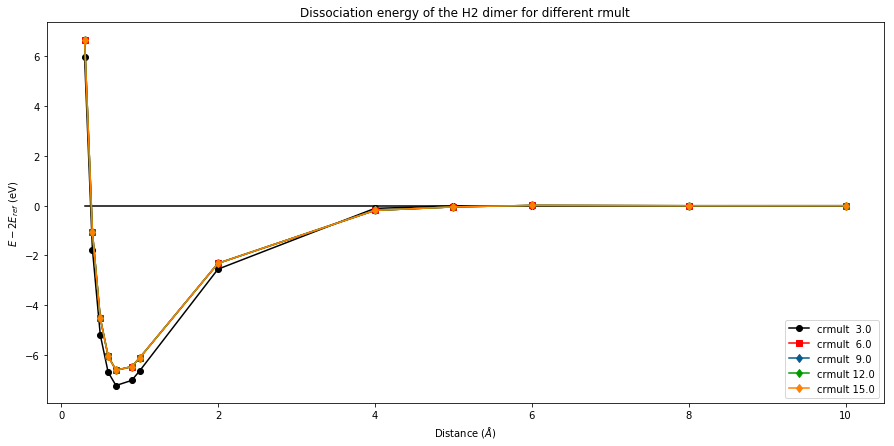

In [5]:
#Build the curve
curves = [ {'energies': [], 'distances': [], 'legend': "crmult %4.1f" % r} for r in crmult]
for (r,d,e) in zip(data['rmult'],data['distances'],data['energies']):
    i = crmult.index(float(r))
    curves[i]['energies'].append(e)
    curves[i]['distances'].append(d)

import matplotlib.pyplot as plt
import numpy as np
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

plt.figure(figsize=(15,7))
# Plot with matplotlib
for i, dat in enumerate(curves):
    im = i%len(colors)
    if i == 0: plt.plot(dat['distances'],np.zeros_like(dat['energies']),'k-')
    plt.plot(dat['distances'], dat['energies'], marker=markers[im], 
             ls='-', label=dat['legend'],color=colors[im])  

#plt.ylim([-24.4, -24.2])
#plt.xlim([6.0, 10.0])
plt.xlabel('Distance ($\AA$)')
plt.ylabel('$E-2E_{ref}$ (eV)')
plt.title('Dissociation energy of the H2 dimer for different rmult')
plt.legend(loc=4)
plt.show()

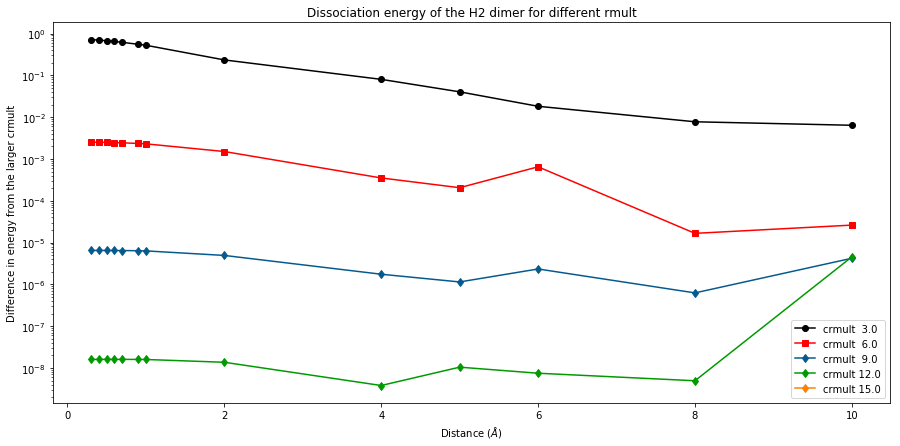

In [6]:
#Build the curve
curves = [ {'energies': [], 'distances': [], 'legend': "crmult %4.1f" % r} for r in crmult]
for (r,d,e) in zip(data['rmult'],data['distances'],data['energies']):
    i = crmult.index(float(r))
    curves[i]['energies'].append(e)
    curves[i]['distances'].append(d)

import matplotlib.pyplot as plt
import numpy as np
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

plt.figure(figsize=(15,7))
# Plot with matplotlib
for i, dat in enumerate(curves):
    im = i%len(colors)
    #if i == 0: plt.plot(dat['distances'],np.zeros_like(dat['energies']),'k-')
    diff = [ abs(d-e) for (d,e) in zip(dat['energies'],curves[-1]['energies'])]
    plt.plot(dat['distances'], diff, marker=markers[im], 
             ls='-', label=dat['legend'],color=colors[im])  

#plt.ylim([-1.0, 0])
#plt.xlim([0.3, 5.0])
plt.yscale('log')
plt.xlabel('Distance ($\AA$)')
plt.ylabel('Difference in energy from the larger crmult')
plt.title('Dissociation energy of the H2 dimer for different rmult')
plt.legend(loc=4)
plt.show()

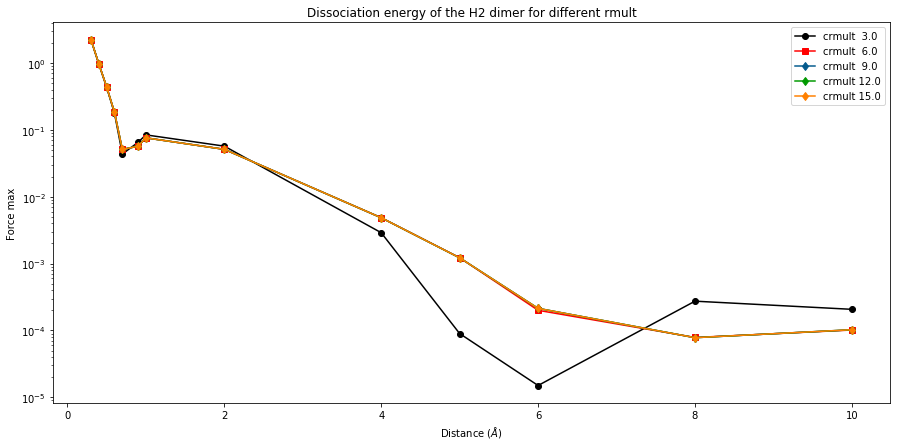

In [7]:
#Build the curve
curves = [ {'forcemax': [], 'distances': [], 'legend': "crmult %4.1f" % r} for r in crmult]
for (r,d,e) in zip(data['rmult'],data['distances'],data['forcemax']):
    i = crmult.index(float(r))
    curves[i]['forcemax'].append(e)
    curves[i]['distances'].append(d)

import matplotlib.pyplot as plt
import numpy as np
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

plt.figure(figsize=(15,7))
# Plot with matplotlib
for i, dat in enumerate(curves):
    im = i%len(colors)
    if i == 0: plt.plot(dat['distances'],np.zeros_like(dat['forcemax']),'k-')
    plt.plot(dat['distances'], dat['forcemax'], marker=markers[im], 
             ls='-', label=dat['legend'],color=colors[im])  

#plt.ylim([-1.0, 0])
#plt.xlim([0.3, 5.0])
plt.yscale('log')
plt.xlabel('Distance ($\AA$)')
plt.ylabel('Force max')
plt.title('Dissociation energy of the H2 dimer for different rmult')
plt.legend(loc=1)
plt.show()

## H2 dissociation energy in function of rmult

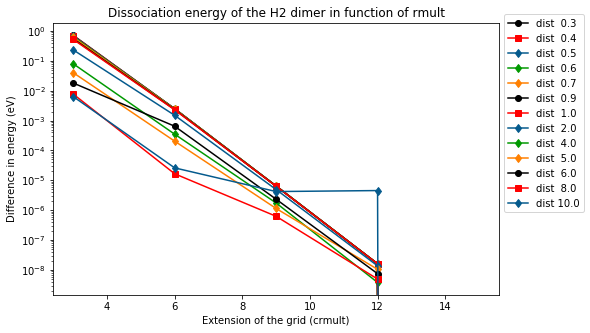

In [8]:
#Build the curve
curves = [ {'energies': [], 'rmult': [], 'legend': "dist %4.1f" % d} for d in distances]
for (r,d,e) in zip(data['rmult'],data['distances'],data['energies']):
    i = distances.index(float(d))
    curves[i]['energies'].append(e)
    curves[i]['rmult'].append(r)

import matplotlib.pyplot as plt
import numpy as np
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

plt.figure(figsize=(8,5))
# Plot with matplotlib
for i, dat in enumerate(curves):
    im = i%len(colors)
    diff = [ abs(d - dat['energies'][-1]) for d in dat['energies']]
    plt.plot(dat['rmult'], diff, marker=markers[im], 
             ls='-', label=dat['legend'], color=colors[im])
#plt.plot(data['rmult'],np.zeros_like(data['energies']),'k-')
#plt.ylim([-1.0, 0])
#plt.xlim([0.3, 5.0])
plt.yscale('log')
plt.xlabel('Extension of the grid (crmult)')
plt.ylabel('Difference in energy (eV)')
plt.title('Dissociation energy of the H2 dimer in function of rmult')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

To avoid running all calculation, we create two archive tar file:
* one containing all logs _log-dimer*_
* another one containing all data for the templates (_log-h2o*_ and mainly _data-h2o*_)

In [9]:
#First archive file (log to analyse)
if not os.path.exists(tarname):
    import tarfile
    tar = tarfile.open(tarname,"w:bz2")
    for name in glob.glob("log-H*.yaml"):
        tar.add(name)
    tar.close()
    print "Creation of a tar file with all log files: %s" % tarname
else:
    print "No creation of tarfile %s because it already exists!" % tarname

No creation of tarfile log-H2-LDA-dissociation.tar.bz2 because it already exists!
